In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fft_file = np.load('../fft_matrices_small.npz')
in_fft = fft_file['fft_in']
out_fft = fft_file['fft_out']

In [4]:
in_first = in_fft[0]
out_first = out_fft[0]

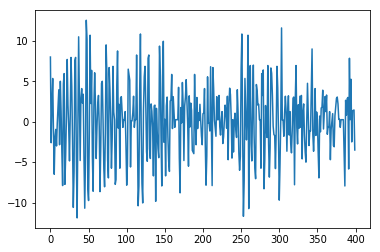

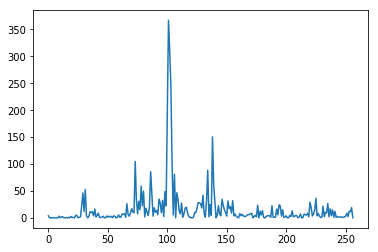

In [5]:
plt.figure()
plt.plot(in_first)
plt.figure()
plt.plot(out_first)

In [6]:
N = 512
K_ = 512

weights = np.zeros((512, 512), dtype=np.complex)

out = []
for k in range(0,K_):
    x_out = 0
    for n in range(0, N):
        w = np.exp(-1j*k*n*((2*np.pi)/N))
        weights[k, n] = w 
        if n < len(in_first):
            x_n = in_first[n] * w
        else:
            x_n = 0 * w
        x_out += x_n
    out.append(x_out)
out = np.asarray(out)

/home/timo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


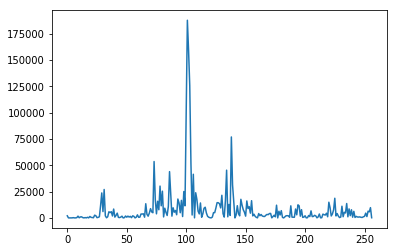

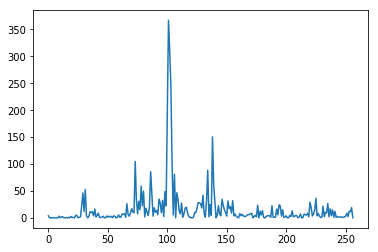

In [7]:
from keras import backend as K

weights = np.zeros((512, 400, 2))
for k in range(0,K_):
    for n in range(0, 400):
        w = np.exp(-1j*k*n*((2*np.pi)/N))
        weights[k, n, 0] = w.real
        weights[k, n, 1] = w.imag


        
def activation(in_first):
    s = in_first
    s = K.expand_dims(s, 1)
    prod = (weights.transpose() * s)
    aggregated = K.sum(prod, axis=1)
    out_agg = K.sum(K.square(aggregated), axis=0)
    return out_agg
    
out = K.eval(activation(in_first))
plt.plot(out[:257])
plt.figure()
plt.plot(out_first)

In [173]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class FftLayer(Layer):
    def __init__(self, NFFT=512, **kwargs):
        self._NFFT = NFFT
        super(FftLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        np_we =  np.zeros((self._NFFT, input_shape[1], 2))
        for k in range(0, self._NFFT):
            for n in range(0, input_shape[1]):
                w = np.exp(-1j*k*n*((2*np.pi)/self._NFFT))
                np_we[k, n, 0]  = w.real
                np_we[k, n, 1] = w.imag
        self.we = K.variable(np_we.transpose(2,1,0))
        self._trainable_weights.append(self.we)
        super(FftLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        sum_real = K.dot(x, self.we[0])
        sum_imag = K.dot(x, self.we[1])
        aggregated = K.stack([sum_real, sum_imag], axis=1)        
        out_agg = K.sum(K.square(aggregated), axis=1)
        return out_agg[:,:257] * (1.0 / self._NFFT)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 257)

In [182]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    FftLayer(input_shape=(400,), trainable=False)
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fft_layer_52 (FftLayer)      (None, 257)               409600    
Total params: 409,600
Trainable params: 0
Non-trainable params: 409,600
_________________________________________________________________


In [69]:
x_batch = K.ones(shape=(2, 512, 400))
y_batch = K.ones(shape=(400, 1))
xy_batch_dot = K.dot(x_batch, y_batch)
K.int_shape(xy_batch_dot)

(2, 512, 1)

In [81]:
x_batch = K.ones(shape=(1000, 20))
y_batch = K.ones(shape=(1000, 30, 20))
xy_batch_dot = K.batch_dot(x_batch, y_batch, axes=(1,2))
K.int_shape(xy_batch_dot)

ValueError: Dimensions must be equal, but are 20 and 30 for 'Mul_2' (op: 'Mul') with input shapes: [20,1000], [30,20].

In [23]:
in_fft.shape

(1000, 400)

In [47]:
a = np.zeros((2, 512, 400))
b = np.zeros((400))

In [52]:
np.dot(a, b).shape

(2, 512)

In [49]:
(a*b).shape

(2, 512, 400)

In [176]:
x = in_fft[:2]
y = model.predict(x)

In [170]:
y.shape

(2, 257)

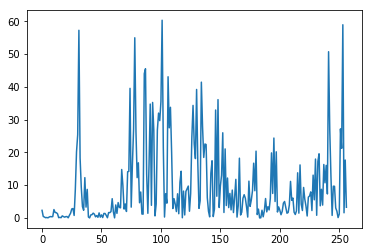

In [177]:
plt.plot(y[1].transpose())

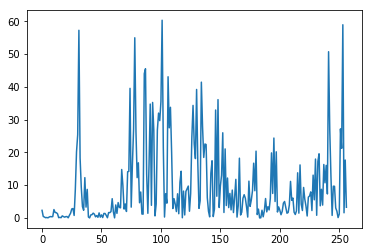

In [178]:
plt.plot(out_fft[1])

In [181]:
y[1] - out_fft[1]

array([ 2.09808346e-07,  9.31978251e-08, -2.25550335e-08, -2.50049295e-09,
       -4.86369667e-08,  4.21243560e-08, -1.07740693e-07,  3.67335553e-07,
        1.35102837e-07,  3.90585094e-07,  2.87575170e-07,  5.61909175e-07,
        5.80196186e-07, -6.36489885e-07, -2.06774438e-07, -7.64747257e-08,
       -5.17827193e-08,  5.17525861e-08,  1.68962372e-07, -1.95538583e-07,
       -1.56412322e-08, -3.90199310e-07, -1.93049788e-08, -5.17800792e-07,
       -2.81631404e-07,  1.61302715e-06, -7.24776745e-08,  2.66305896e-06,
       -2.51543716e-06,  4.98453733e-06,  1.35589898e-05, -1.09146712e-05,
       -1.44840074e-05,  3.60230993e-07, -2.06569281e-06,  5.91505274e-07,
       -5.67661043e-06,  4.73166272e-07,  1.19903161e-06,  3.54544300e-07,
        9.39381891e-09,  3.70261370e-07, -2.87395746e-07, -2.58788674e-07,
        2.70842548e-07, -1.09622996e-07,  5.38662404e-09, -1.79880179e-07,
        9.82329854e-07,  1.83952549e-07, -5.24753928e-07,  1.83922272e-07,
       -2.19206477e-07, -